# Unstructured Data Analysis - Final Project

### Table of Contents
1. [Load Data and EDA](#load-data)
1. [Data Cleaning](#cleaning)
1. [Labelling](#labelling)
1. [Balancing](#balancing)
1. [Text Pre-processing](#text-prepro)
1. [Tweet Sentiment Analysis](#sentiment)

Load libraries and setup

In [1]:
import time
start_time = time.time()

import csv
import re

import spacy
import torch

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    classification_report,
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from tqdm import tqdm
from transformers import (
    AutoTokenizer, 
    AutoConfig, 
    AutoModelForSequenceClassification, 
    logging
)
from typing import List
from scipy.special import softmax
from wordcloud import WordCloud

np.random.seed(70103)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)
logging.set_verbosity_warning()

## 1. Load Data and EDA <a class="anchor" id="load-data"></a>

In [2]:
file_path = "./datasets/vaccination_all_tweets.csv"
vax_df = pd.read_csv(file_path)
vax_df = vax_df.sort_values(by="date")

# Size of the data
print(
    f"{file_path.split('/')[-1]} contains {vax_df.shape[0]} rows and {vax_df.shape[1]} columns."
)
print(
    f"The earliest tweet was from {vax_df['date'].min()} and the latest tweet from {vax_df['date'].max()}"
)

# List of column names in the dataset
print(f"Column names: {list(vax_df.columns)}")

# Show a examples of rows
display(vax_df.head(3))

vaccination_all_tweets.csv contains 228207 rows and 16 columns.
The earliest tweet was from 2020-12-12 11:55:28 and the latest tweet from 2021-11-23 20:58:08
Column names: ['id', 'user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'text', 'hashtags', 'source', 'retweets', 'favorites', 'is_retweet']


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
44,1337727767551553536,Daily News Egypt,Egypt,Egypt's Only Daily Independent Newspaper in English,2009-04-26 07:56:24,278080,116,765,True,2020-12-12 11:55:28,#FDA authorizes #PfizerBioNTech #coronavirus vaccine for emergency use\nhttps://t.co/VZ6bDPbbPG,"['FDA', 'PfizerBioNTech', 'coronavirus']",Twitter Web App,1,1,False
43,1337728701820268544,City A.M.,"London, England","London's business newspaper - News, Opinion, and Analysis. For all distribution queries, see @CityAMDist.",2009-06-09 13:53:06,66224,603,771,True,2020-12-12 11:59:10,Trump announces #vaccine rollout 'in less than 24 hours'\n\nThe first Americans will be vaccinated against… https://t.co/6379SZjNQi,['vaccine'],Twitter Web App,0,2,False
42,1337732077278662657,mystic,NaN,I believe in the goodness of humanity.,2020-05-20 10:57:00,14,162,1341,False,2020-12-12 12:12:35,#CovidVaccine #Pfizer-BioNTech COVID-19 #PfizerBioNTech #COVID19 #CapeTown https://t.co/uCpwv0S4nl,"['CovidVaccine', 'Pfizer', 'PfizerBioNTech', 'COVID19', 'CapeTown']",Twitter for iPhone,0,1,False


### Missing Data
Columns with missing (NaN/null) data

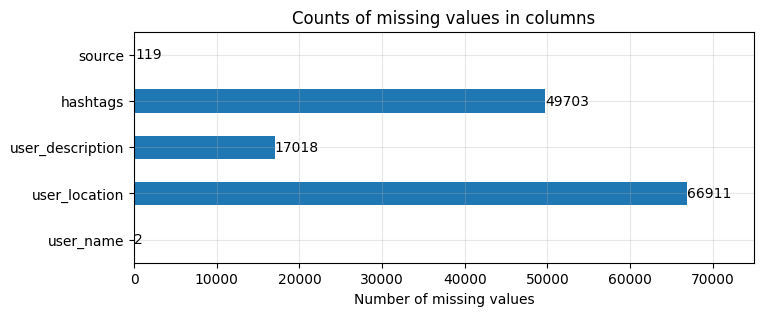

In [3]:
# Visualise the number of missing 
fig, ax = plt.subplots(figsize=(8, 3))
null_counts = vax_df.isnull().sum()
ax = null_counts.loc[null_counts > 0].plot.barh()
ax.grid(alpha=0.3)
ax.bar_label(ax.containers[0])
ax.set_title("Counts of missing values in columns")
ax.set_xlim([0, 75000])
ax.set_xlabel("Number of missing values")
plt.show()

fig.savefig("./report_media/missing_counts_bar.png")

many missing `hashtags` and `user_location` which is expected. no missing values in `text` column.

Missing dates - Some dates appear to have no tweets

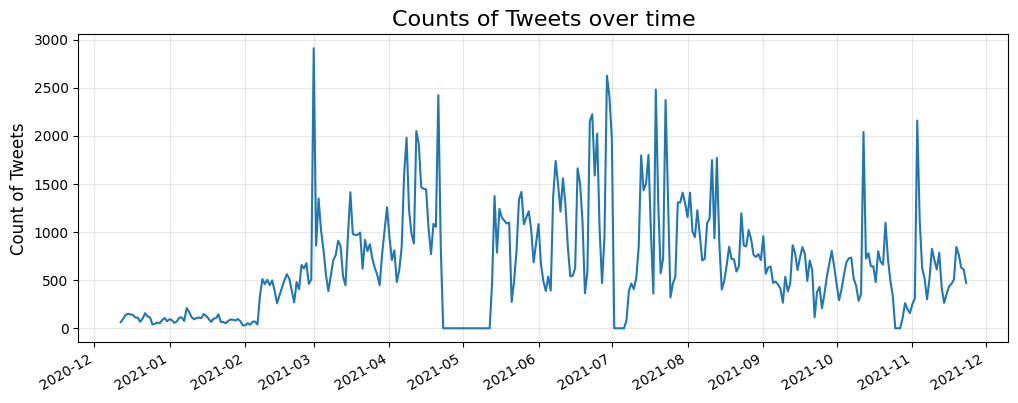

In [4]:
vax_df["fulldate"] = pd.to_datetime(vax_df["date"]).dt.date
start_date = vax_df["fulldate"].min()
end_date = vax_df["fulldate"].max()
dates = pd.DataFrame(pd.date_range(start=start_date, end=end_date), columns=["fulldate"])
dates["fulldate"] = pd.to_datetime(dates["fulldate"]).dt.date

id_counts_by_date = (
    vax_df[["fulldate", "id"]]
        .groupby("fulldate")["id"]
        .count()
        .reset_index(name="count")
    )

id_counts_by_date_all = pd.merge(id_counts_by_date, dates, on="fulldate", how="outer")
id_counts_by_date_all["count"] = id_counts_by_date_all["count"].fillna(0)
id_counts_by_date_all = id_counts_by_date_all.sort_values(by="fulldate", ascending=True)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(id_counts_by_date_all["fulldate"], id_counts_by_date_all["count"])
ax.grid(alpha=0.3)
ax.set_title("Counts of Tweets over time", fontsize=16)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax.set_ylabel("Count of Tweets", fontsize=12)

plt.show()

fig.savefig("./report_media/tweet_count_over_time.png")

### Duplicate Rows

Showing an example of identical tweet from different people at different times

In [5]:
vax_df.loc[vax_df["text"] == "Boosted! #moderna", ["user_name", "user_location", "date", "text"]]

,user_name,user_location,date,text
218116,Grace Schmitz,"Calumet, MI",2021-11-05 14:33:14,Boosted! #moderna
225230,Natasja S,United Kingdom,2021-11-15 17:41:46,Boosted! #moderna
224386,Gary Wien,"New Jersey, USA",2021-11-19 17:40:11,Boosted! #moderna


Showing duplicate rows with identical `text`, `user_name` and `fulldate`

In [6]:
# show all the duplicates
vax_df.loc[
    vax_df.duplicated(subset=["text", "user_name", "fulldate"]), 
    ["user_name", "date", "text"]
].sort_values(by=["user_name", "date"]).tail()

,user_name,date,text
19597,jorge mora,2021-03-03 01:50:39,@POTUS What about #Covaxin from #Ocugen ?! It seems like it's better than anything we have now! Is it coming to the US? Why or why not??
19596,jorge mora,2021-03-03 01:52:16,@POTUS What about #Covaxin from #Ocugen ?! It seems like it's better than anything we have now! Is it coming to the US? Why or why not??
19595,jorge mora,2021-03-03 01:53:30,@POTUS What about #Covaxin from #Ocugen ?! It seems like it's better than anything we have now! Is it coming to the US? Why or why not??
19594,jorge mora,2021-03-03 01:53:53,@POTUS What about #Covaxin from #Ocugen ?! It seems like it's better than anything we have now! Is it coming to the US? Why or why not??
220013,joseph,2021-11-10 14:41:56,@zainrizvi Stupid greedy drug company. Shameful. #Moderna should share credit with NIH scientists!


In [7]:
vax_df.loc[
    vax_df["text"] == "@RepThomasMassie The vaccine you are referring to is #Covaxin #Ocugen #BharatBiotech", 
    ["user_name", "date", "text"]
]

,user_name,date,text
227204,Craig Gordon,2021-11-18 23:23:15,@RepThomasMassie The vaccine you are referring to is #Covaxin #Ocugen #BharatBiotech
227203,Craig Gordon,2021-11-18 23:23:28,@RepThomasMassie The vaccine you are referring to is #Covaxin #Ocugen #BharatBiotech
227202,Craig Gordon,2021-11-18 23:23:50,@RepThomasMassie The vaccine you are referring to is #Covaxin #Ocugen #BharatBiotech


Some users have many tweets (10k+)

In [8]:
(
    vax_df[["user_name", "source", "id"]]
        .groupby(by=["user_name", "source"])["id"]
        .count().reset_index(name="count")
        .sort_values(["count"], ascending=False)
        .head(10)
)

,user_name,source,count
16043,CowinBangalore,cowin_vaccine_app,11494
15404,CoWIN Blore 18-44,CowinAlertsBot,11276
74353,VaxBLR,VaxBlr,6619
52088,Owl 🦉,Cowin Vaccination Availability,6570
52090,Owl🦉,Cowin Vaccination Availability,1955
76551,Workout Solutions,Twitter for iPhone,1389
79632,eLéPhunk,Twitter for Android,881
15403,CoWIN Blore 18-44,CowinAlertBot,879
76550,Workout Solutions,Twitter Web App,862
12559,COVID News,Revive Social App,505


In [9]:
vax_df.loc[
    vax_df["user_name"] == "CowinBangalore", 
    ["user_name", "date", "text"]
].head(3)

,user_name,date,text
93368,CowinBangalore,2021-06-07 02:31:28,"560011, \nAGE 45+\n0-D1, 50-D2 slots,\n#COVAXIN on 07-06-2021\n@ APOLLO JAYANAGAR-COVAXIN"
93359,CowinBangalore,2021-06-07 02:51:31,"560011, \nAGE 45+\n0-D1, 38-D2 slots,\n#COVAXIN on 07-06-2021\n@ APOLLO JAYANAGAR-COVAXIN"
93235,CowinBangalore,2021-06-07 05:25:30,"560057, \nAGE 45+\n0-D1, 50-D2 slots,\n#COVAXIN on 07-06-2021\n@ NEL COVAXIN"


It appears that accounts such as CowinBangalore posts tweets about covid vaccine slots.

In [10]:
# Look at the sources of tweets
(
    vax_df[["source", "id"]]
        .groupby("source")["id"]
        .count().reset_index(name="count")
        .sort_values(['count'], ascending=False)
        .head(10)
)

,source,count
291,Twitter for Android,58722
286,Twitter Web App,57119
294,Twitter for iPhone,49479
334,cowin_vaccine_app,11670
53,CowinAlertsBot,11276
51,Cowin Vaccination Availability,8525
271,TweetDeck,7329
309,VaxBlr,6619
293,Twitter for iPad,3074
107,Instagram,2235


These bot accounts should be removed in data cleaning

## 2. Data Cleaning <a class="anchor" id="cleaning"></a>
- Only retain columns of interest
- Remove bot accounts and duplicate rows

In [11]:
# Only retain columns of interest
text_df = vax_df[["user_name", "user_location", "fulldate", "text", "source"]]
print(text_df.shape)

# Remove tweets from COWIN bot accounts
cowin_sources = [
    "cowin_vaccine_app", 
    "VaxBlr",
    "CowinAlertBot", 
    "CowinAlertsBot",
    "Cowin Vaccination Availability", 
]
text_df = text_df.loc[~text_df["source"].isin(cowin_sources)]
print(text_df.shape)

# Remove duplicate tweets that is posted within the same day by the same person
text_df = text_df.drop_duplicates(subset=["user_name", "text", "fulldate"], keep="first")
print(text_df.shape)

(228207, 5)
(189238, 5)
(189147, 5)


## 3. Labelling <a class="anchor" id="labelling"></a>
Since the data set does not come with a sentiment label, the "twitter-roberta-base-sentiment-latest" model is used to create a benchmark "ground truth" so that other models can be compared against it.

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available():
    print(f"GPU in use: {torch.cuda.get_device_name(0)}")

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)

def predict_sentiment(text):
    encoded_input = tokenizer(text, return_tensors="pt")
    output = model(**encoded_input.to(device))
    scores = softmax(output[0][0].cpu().detach().numpy())
    return dict(zip(config.id2label.values(), scores))

GPU in use: NVIDIA GeForce GTX 1070


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# ! This step takes a long time to run! ~40 minutes. Only run if necessary.
tqdm.pandas()
text_df["text_sentiment_scores"] = text_df["text"].progress_apply(lambda x: predict_sentiment(x))

100%|██████████| 189147/189147 [37:13<00:00, 84.67it/s]


Use the sentiment with the highest predicted score as the label

In [14]:
text_df["max_score_label"] = text_df["text_sentiment_scores"].progress_apply(
    lambda scores: max(scores, key=scores.get)
)

100%|██████████| 189147/189147 [00:00<00:00, 681574.13it/s]


## 4. Balancing <a class="anchor" id="balancing"></a>

The dataset is imbalanced in the sentiment labels. It is balanced using resampling with replacement.

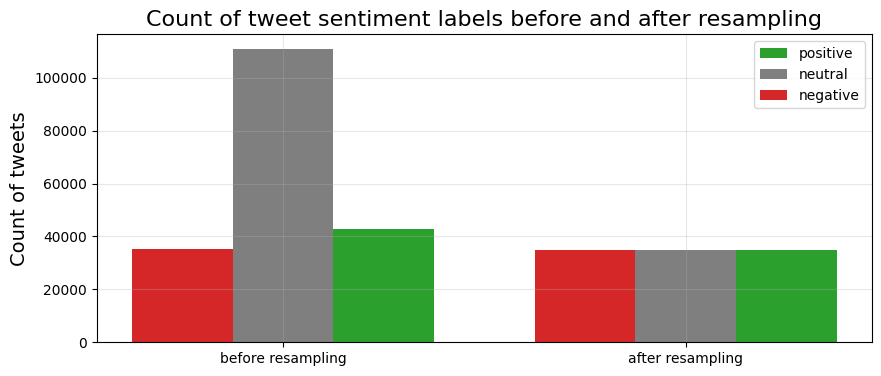

In [15]:
neg_text_df = text_df.loc[text_df["max_score_label"] == "negative"]
neu_text_df = text_df.loc[text_df["max_score_label"] == "neutral"]
pos_text_df = text_df.loc[text_df["max_score_label"] == "positive"]

neg_text_df_resampled = resample(neg_text_df, replace=True, n_samples=35000)
neu_text_df_resampled = resample(neu_text_df, replace=True, n_samples=35000)
pos_text_df_resampled = resample(pos_text_df, replace=True, n_samples=35000)

balanced_text_df = pd.concat(
    [neg_text_df_resampled, neu_text_df_resampled, pos_text_df_resampled],
    ignore_index=True
)

N = 2
ind = np.arange(N)
width = 0.25

before_counts = text_df[["max_score_label"]].value_counts().reset_index(name="before_count")
after_counts = balanced_text_df[["max_score_label"]].value_counts().reset_index(name="after_count")
counts_df = pd.merge(before_counts, after_counts, on="max_score_label", how="inner")

neg_counts = counts_df.loc[
    counts_df["max_score_label"] == "negative", 
    ["before_count", "after_count"]
].values.flatten()

neu_counts = counts_df.loc[
    counts_df["max_score_label"] == "neutral",
    ["before_count", "after_count"]
].values.flatten()

pos_counts = counts_df.loc[
    counts_df["max_score_label"] == "positive",
    ["before_count", "after_count"]
].values.flatten()

# Plot the class balance as a bar plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(ind+2*width, pos_counts, width, color="tab:green", label="positive")
ax.bar(ind+width, neu_counts, width, color="tab:gray", label="neutral")
ax.bar(ind, neg_counts, width, color="tab:red", label="negative")
ax.legend()
ax.grid(alpha=0.3)
ax.set_title("Count of tweet sentiment labels before and after resampling", fontsize=16)
ax.set_xticks(ind+width, ["before resampling", "after resampling"])
ax.set_ylabel("Count of tweets", fontsize=14)
plt.show()
fig.savefig("./report_media/class_imbalance.png")

## 5. Text Pre-processing <a class="anchor" id="text-prepro"></a>

An example of emoji changing the sentiment of a sentence completely. So emojis are kept.

In [16]:
sentences = ["I received a dose of #pfizerbiontech covid-19 vaccine"] * 3
sentences[1] += " 😀"
sentences[2] += " 😟"

emoji_example = pd.DataFrame(sentences, columns=["text"])
emoji_example["text_sentiment_scores"] = emoji_example["text"].progress_apply(lambda x: predict_sentiment(x))
emoji_example["max_score_label"] = emoji_example["text_sentiment_scores"].progress_apply(lambda scores: max(scores, key=scores.get))
display(emoji_example)

100%|██████████| 3/3 [00:00<00:00, 5023.12it/s]


,text,text_sentiment_scores,max_score_label
0,I received a dose of #pfizerbiontech covid-19 vaccine,"{'negative': 0.04958874, 'neutral': 0.83540446, 'positive': 0.11500678}",neutral
1,I received a dose of #pfizerbiontech covid-19 vaccine 😀,"{'negative': 0.0078060045, 'neutral': 0.26736185, 'positive': 0.7248322}",positive
2,I received a dose of #pfizerbiontech covid-19 vaccine 😟,"{'negative': 0.81133777, 'neutral': 0.17565854, 'positive': 0.013003681}",negative


### Basic Cleaning
- remove white space, new line and tab characters
- convert to lower case
- remove URLs.

In [17]:
balanced_text_df["preprocessed_text"] = balanced_text_df["text"].progress_apply(
    lambda x: " ".join(x.strip().split()).lower()
)
# Remove URLs using regular expressions
balanced_text_df["preprocessed_text"] = balanced_text_df["preprocessed_text"].progress_apply(
    lambda x: re.sub(r"http\S+", "", x)
)

100%|██████████| 105000/105000 [00:00<00:00, 431158.32it/s]


### Tokenization and Lemmatization
- Remove punctuation, stop words
- Retain negation words e.g. "no" and "not" which might be stop words

In [18]:
# Removing punctuations and stop words
def preprocess_text(corpus:pd.Series) -> List[List[str]]:
    """ A function to pre-process the text data 
    before TFIDF embedding."""

    # Initialise array for pre processed summary texts
    processed_text = []
    processed_text_no_nouns = []

    # Pre-processing using spacy pipelines
    nlp = spacy.load("en_core_web_sm")
    nlp.vocab["no"].is_stop = False
    nlp.vocab["never"].is_stop = False
    nlp.vocab["not"].is_stop = False

    for doc in tqdm(nlp.pipe(corpus), total=len(corpus)):
        tokens_lemmatized = [
            token.lemma_ for token in doc

            # Remove stop words
            if (not token.is_stop)

            # Remove punctuation
            and (not token.is_punct)
        ]

        tokens_lemmatized_no_nouns = [
            token.lemma_ for token in doc

            # Remove stop words
            if (not token.is_stop)

            # Remove punctuation
            and (not token.is_punct)

            #remove nouns and proper nouns depending on use case
            and not (token.pos_ in ["NOUN", "PROPN"])
        ]

        # append the processed review summary to array
        processed_text.append(" ".join(tokens_lemmatized))
        processed_text_no_nouns.append(" ".join(tokens_lemmatized_no_nouns))

    return processed_text, processed_text_no_nouns

balanced_text_df["preprocessed_text"], balanced_text_df["preprocessed_text_no_noun"] = preprocess_text(balanced_text_df["preprocessed_text"])

# Remove rows that no longer contain any text after pre-processing
balanced_text_df = balanced_text_df.dropna(subset=["preprocessed_text", "preprocessed_text_no_noun"])

100%|██████████| 105000/105000 [02:56<00:00, 595.75it/s]


Since the pre-processing takes a very long time, the results are saved as a csv

In [19]:
outpath = "./datasets/reduced_and_balanced_vaccination_tweets.csv"
balanced_text_df.to_csv(outpath, index=False, quoting=csv.QUOTE_ALL)
print(balanced_text_df.shape)

(105000, 9)


Reload the dataframe as a new variable.

In [20]:
reduced_df = pd.read_csv(outpath)
print(reduced_df.shape)

(105000, 9)


## 6. Tweet Sentiment Analysis <a class="anchor" id="sentiment"></a>

### Count and percentage of sentiment labels for each vaccine manufacturer

,covaxin,sinopharm,sinovac,moderna,pfizer|biontech,oxford|astrazeneca,sputnik
sentiment,,,,,,,
negative,6057,1254,1727,8624,4532,1800,2472
neutral,8033,2253,2329,7885,4292,1398,3886
positive,7609,750,2113,12069,3818,1205,1730


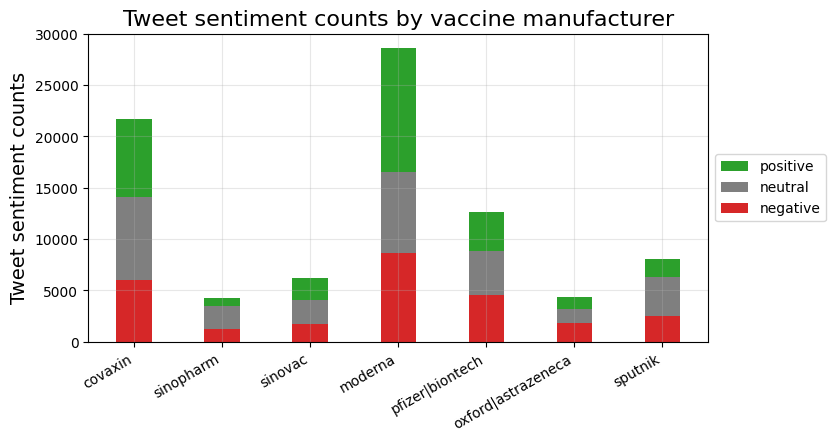

In [21]:
all_vax = ["covaxin", "sinopharm", "sinovac", "moderna", "pfizer|biontech", "oxford|astrazeneca", "sputnik"]

df = pd.DataFrame(["negative", "neutral", "positive"], columns=["sentiment"])
for name in all_vax:
    temp_df = reduced_df.loc[reduced_df["preprocessed_text"].str.contains(name), "max_score_label"].value_counts().reset_index(name=name).rename(columns={"index": "sentiment"})
    df = pd.merge(df, temp_df, on="sentiment", how="inner")

counts_df = df.set_index("sentiment")
display(counts_df)

neg = counts_df.loc["negative"].values.flatten()
neu = counts_df.loc["neutral"].values.flatten()
pos = counts_df.loc["positive"].values.flatten()

# Create bar plot of tweet counts by vaccine manufacturers and sentiment label counts
fig, ax = plt.subplots(figsize=(8, 4))
width = 0.4
ax.bar(all_vax, pos, width, label="positive", color="tab:green", bottom=neg+neu)
ax.bar(all_vax, neu, width, label="neutral", color="tab:gray", bottom=neg)
ax.bar(all_vax, neg, width, label="negative", color="tab:red")
ax.set_ylabel("Tweet sentiment counts", fontsize=14)
ax.set_title("Tweet sentiment counts by vaccine manufacturer", fontsize=16)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.grid(alpha=0.3)

for label in ax.get_xticklabels(which="major"):
    label.set(rotation=30, horizontalalignment="right")

fig.savefig("./report_media/sentiment_count.png", bbox_inches='tight', pad_inches=0.1)

plt.show()

,covaxin,sinopharm,sinovac,moderna,pfizer|biontech,oxford|astrazeneca,sputnik
sentiment,,,,,,,
negative,27.9,29.5,28.0,30.2,35.8,40.9,30.6
neutral,37.0,52.9,37.8,27.6,34.0,31.8,48.0
positive,35.1,17.6,34.3,42.2,30.2,27.4,21.4


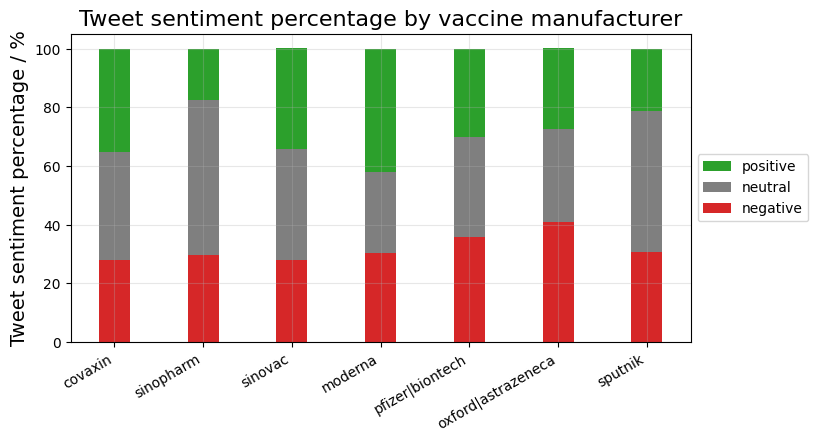

In [22]:
pct_df = (100 * counts_df / counts_df.sum()).round(1)
display(pct_df)

neg = pct_df.loc["negative"].values.flatten()
neu = pct_df.loc["neutral"].values.flatten()
pos = pct_df.loc["positive"].values.flatten()

# Create bar plot of tweet counts by vaccine manufacturers and sentiment label proportions
fig, ax = plt.subplots(figsize=(8, 4))
width = 0.35
ax.bar(all_vax, pos, width, label="positive", color="tab:green", bottom=neg+neu)
ax.bar(all_vax, neu, width, label="neutral", color="tab:gray", bottom=neg)
ax.bar(all_vax, neg, width, label="negative", color="tab:red")
ax.set_ylabel("Tweet sentiment percentage / %", fontsize=14)
ax.set_title("Tweet sentiment percentage by vaccine manufacturer", fontsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(alpha=0.3)

for label in ax.get_xticklabels(which="major"):
    label.set(rotation=30, horizontalalignment="right")

fig.savefig("./report_media/sentiment_percentage.png", bbox_inches='tight', pad_inches=0.1)

plt.show()

### Proportion of tweet sentiments over time

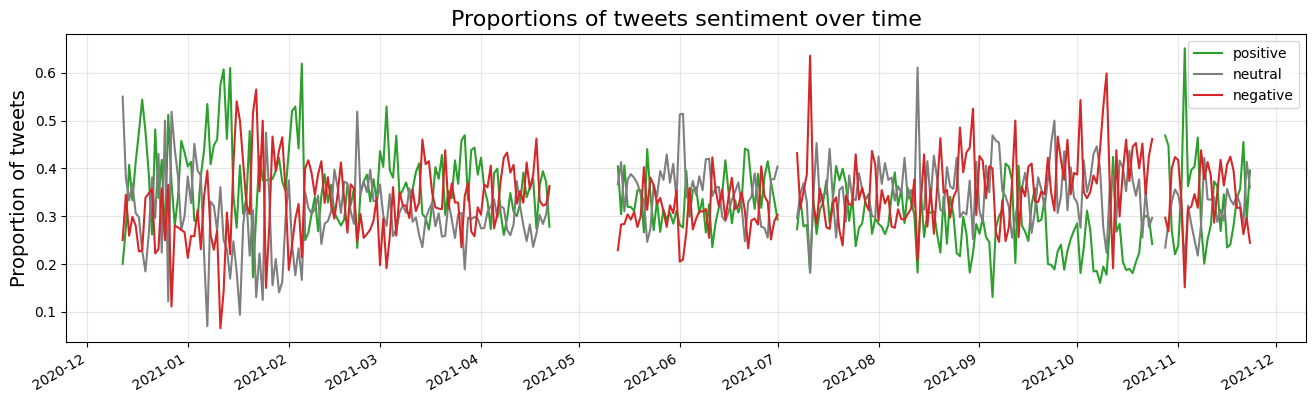

In [23]:
date_count_df = reduced_df.groupby("fulldate").value_counts(subset=["max_score_label"]).reset_index(name="count")

pivot_date_count_df = date_count_df.pivot(index="fulldate", columns="max_score_label", values="count").reset_index()

start_date = reduced_df["fulldate"].min()
end_date = reduced_df["fulldate"].max()
all_dates = pd.DataFrame(pd.date_range(start=start_date, end=end_date), columns=["fulldate"])
all_dates["fulldate"] = pd.to_datetime(all_dates["fulldate"]).dt.date

pivot_date_count_df["fulldate"] = pd.to_datetime(pivot_date_count_df["fulldate"]).dt.date
pivot_date_count_all = pd.merge(pivot_date_count_df, all_dates, on="fulldate", how="outer").fillna(0).sort_values(by="fulldate")

counts = list(zip(pivot_date_count_all["negative"], pivot_date_count_all["neutral"], pivot_date_count_all["positive"]))
percentages = [[None if np.isclose(np.array(date_counts).sum(), 0) else v/np.array(date_counts).sum() for v in date_counts] for date_counts in counts]

neg_pct = [p[0] for p in percentages]
neu_pct = [p[1] for p in percentages]
pos_pct = [p[2] for p in percentages]

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(pivot_date_count_all["fulldate"], pos_pct, color="tab:green", label="positive")
ax.plot(pivot_date_count_all["fulldate"], neu_pct, color="tab:gray", label="neutral")
ax.plot(pivot_date_count_all["fulldate"], neg_pct, color="tab:red", label="negative")
ax.grid(alpha=0.3)

# Text in the x axis will be displayed in "YYYY-mm" format.
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Rotates and right-aligns the x labels so they don"t crowd each other.
for label in ax.get_xticklabels(which="major"):
    label.set(rotation=30, horizontalalignment="right")

ax.set_title("Proportions of tweets sentiment over time", fontsize=16)
ax.set_ylabel("Proportion of tweets", fontsize=14)
ax.legend()
plt.show()

fig.savefig("./report_media/time_sentiment.png")

### Word clouds of sentiment

Negative top 10 words (before filtering): [('vaccine', 11702), ('moderna', 8756), ('covaxin', 6331), ('not', 6121), ('covid19', 3596), ('pfizer', 3437), ('no', 2925), ('dose', 2865), ('people', 2437), ('get', 2227)]
Negative top 10 words (after filtering): [('not', 6121), ('no', 2925), ('dose', 2865), ('get', 2227), ('sputnikv', 2168), ('sinovac', 1809), ('report', 1730), ('second', 1504), ('like', 1491), ('shot', 1384)]


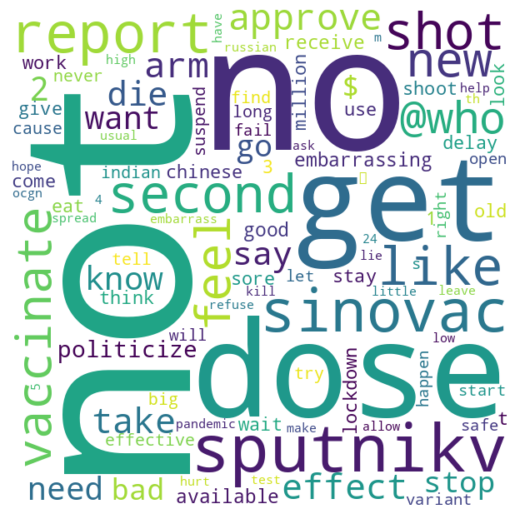

Neutral top 10 words (before filtering): [('vaccine', 14187), ('covaxin', 8690), ('moderna', 8236), ('dose', 6305), ('covid19', 4122), ('sputnikv', 3264), ('pfizer', 3074), ('covid-19', 2497), ('sinovac', 2447), ('india', 2393)]
Neutral top 10 words (after filtering): [('dose', 6305), ('sputnikv', 3264), ('sinovac', 2447), ('get', 1954), ('vaccinate', 1855), ('approve', 1759), ('receive', 1698), ('say', 1577), ('shot', 1480), ('not', 1463)]


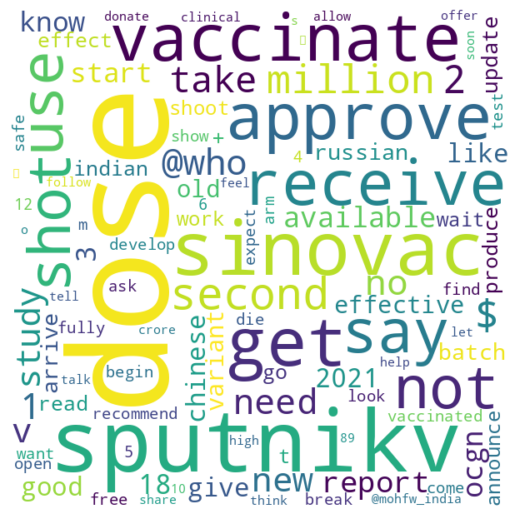

Positive top 10 words (before filtering): [('moderna', 12546), ('vaccine', 10564), ('covaxin', 8043), ('dose', 6117), ('get', 6092), ('vaccinate', 5169), ('thank', 4132), ('💉', 3850), ('today', 3606), ('good', 2768)]
Positive top 10 words (after filtering): [('dose', 6117), ('get', 6092), ('vaccinate', 5169), ('thank', 4132), ('good', 2768), ('second', 2502), ('shot', 2231), ('sinovac', 2207), ('$', 2019), ('fully', 1918)]


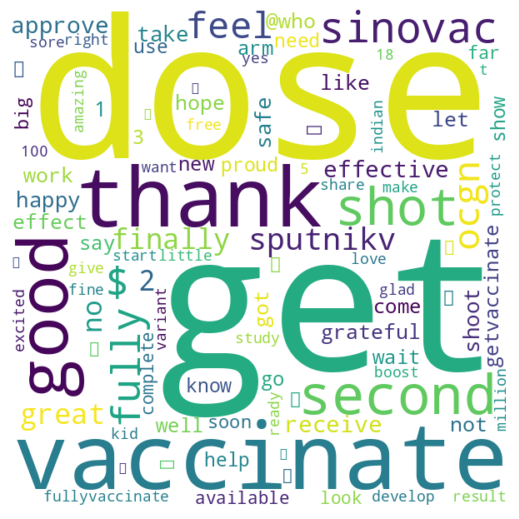

In [24]:
def count_words(df: pd.DataFrame, sentiment_label: str) -> Counter:
    """Creater word counter for sentiment label in dataframe"""
    counter = Counter()
    for text in df.loc[df["max_score_label"] == sentiment_label, "preprocessed_text"].values:
        for word in text.split():
            counter[word] += 1
    return counter

def filter_count_words(word_counter: Counter, top_n: int = 500) -> Counter:
    """Filter word counter for nouns and proper nouns and only retain the top_n words"""
    top_n_counter = word_counter.most_common(top_n)
    keys = [key for key, _ in top_n_counter]
    nlp = spacy.load("en_core_web_sm")
    keep_keys = [
        token.text 
        for doc in nlp.pipe(keys) 
        for token in doc
        if token.pos_ not in ["NOUN", "PROPN"]
    ]
    return Counter({key: dict(top_n_counter)[key] for key in keep_keys})


# Negative - most frequent 10 words (with and without nouns) + Word Cloud
neg_words = count_words(reduced_df, "negative")
print(f"Negative top 10 words (before filtering): {neg_words.most_common(10)}")
filtered_neg_words = filter_count_words(neg_words, top_n=500)
print(f"Negative top 10 words (after filtering): {filtered_neg_words.most_common(10)}")

wc = WordCloud(width=600, height=600, background_color="white", max_words=100)

fig, ax = plt.subplots(figsize=(5, 5))
wc.generate_from_frequencies(filtered_neg_words)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
fig.savefig("./report_media/neg_cloud.png")

# Neutral - most frequent 10 words (with and without nouns) + Word Cloud
neu_words = count_words(reduced_df, "neutral")
print(f"Neutral top 10 words (before filtering): {neu_words.most_common(10)}")
filtered_neu_words = filter_count_words(neu_words, top_n=500)
print(f"Neutral top 10 words (after filtering): {filtered_neu_words.most_common(10)}")

fig, ax = plt.subplots(figsize=(5, 5))
wc.generate_from_frequencies(filtered_neu_words)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
fig.savefig("./report_media/neu_cloud.png", pad_inches=0)


# Positive - most frequent 10 words (with and without nouns) + Word Cloud
pos_words = count_words(reduced_df, "positive")
print(f"Positive top 10 words (before filtering): {pos_words.most_common(10)}")
filtered_pos_words = filter_count_words(pos_words, top_n=500)
print(f"Positive top 10 words (after filtering): {filtered_pos_words.most_common(10)}")

fig, ax = plt.subplots(figsize=(5, 5))
wc.generate_from_frequencies(filtered_pos_words)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
fig.savefig("./report_media/pos_cloud.png")

### Logistic Regression

First with no nouns

In [25]:
# Extract the inputs and outputs
X_no_noun = reduced_df.loc[~reduced_df["preprocessed_text_no_noun"].isna(), "preprocessed_text_no_noun"]
y_no_noun = reduced_df.loc[~reduced_df["preprocessed_text_no_noun"].isna(), "max_score_label"]

# Split the data into train and test set with 80-20 split
X_train_no_noun, X_test_no_noun, y_train_no_noun, y_test_no_noun = train_test_split(X_no_noun, y_no_noun, test_size=0.2, random_state=0)

#### Count Vectorization

Classifier Train Accuracy: 73.45%
Classifier Test Accuracy: 71.17%


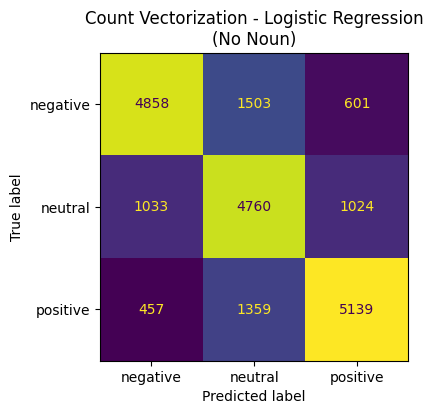

              precision    recall  f1-score   support

    negative       0.77      0.70      0.73      6962
     neutral       0.62      0.70      0.66      6817
    positive       0.76      0.74      0.75      6955

    accuracy                           0.71     20734
   macro avg       0.72      0.71      0.71     20734
weighted avg       0.72      0.71      0.71     20734



In [26]:
# Extract vectorised features from the text data 
# with count word embedding.
countvec_no_noun = CountVectorizer(max_features=2500)

# Fit count vectorisation on training data and
# transform the test data with the fitted vectoriser
X_train_countvec_no_noun = countvec_no_noun.fit_transform(X_train_no_noun)
X_test_countvec_no_noun = countvec_no_noun.transform(X_test_no_noun)

# Fit a logistic regression model to classify the reviews.
countvec_no_noun_model = LogisticRegression(max_iter=500)
countvec_no_noun_model.fit(X_train_countvec_no_noun, y_train_no_noun)

train_pred_class = countvec_no_noun_model.predict(X_train_countvec_no_noun)
test_pred_class = countvec_no_noun_model.predict(X_test_countvec_no_noun)
train_acc_score = accuracy_score(y_train_no_noun, train_pred_class) * 100
test_acc_score = accuracy_score(y_test_no_noun, test_pred_class) * 100
print(f"Classifier Train Accuracy: {train_acc_score:.2f}%")
print(f"Classifier Test Accuracy: {test_acc_score:.2f}%")

fig, ax = plt.subplots(figsize=(4, 4))
cm = confusion_matrix(y_test_no_noun, test_pred_class, labels=countvec_no_noun_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=countvec_no_noun_model.classes_)
disp.plot(ax=ax)
disp.im_.colorbar.remove()
disp.ax_.set_title("Count Vectorization - Logistic Regression\n(No Noun)")
plt.show()
fig.savefig("./report_media/countvec_cm_nonoun.png")

print(classification_report(y_test_no_noun, test_pred_class))

#### TF-IDF Vectorization

Classifier Train Accuracy: 73.25%
Classifier Test Accuracy: 71.16%


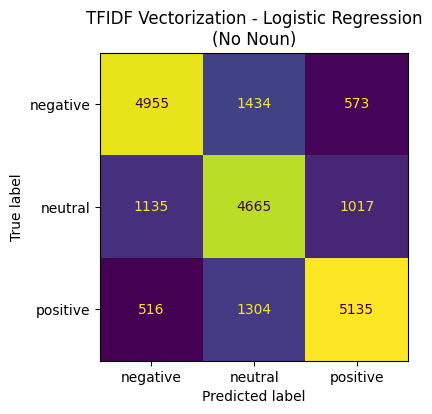

              precision    recall  f1-score   support

    negative       0.75      0.71      0.73      6962
     neutral       0.63      0.68      0.66      6817
    positive       0.76      0.74      0.75      6955

    accuracy                           0.71     20734
   macro avg       0.71      0.71      0.71     20734
weighted avg       0.72      0.71      0.71     20734



In [27]:
# Extract vectorised features from the text data 
# with TF-IDF word embedding.
tfidf_no_noun = TfidfVectorizer(max_features=2500)

# Fit tf-idf vectorisation on training data and
# transform the test data with the fitted vectoriser
X_train_tfidf_no_noun = tfidf_no_noun.fit_transform(X_train_no_noun)
X_test_tfidf_no_noun = tfidf_no_noun.transform(X_test_no_noun)

# Fit a logistic regression model to classify the reviews.
tfidf_no_noun_model = LogisticRegression(max_iter=500)
tfidf_no_noun_model.fit(X_train_tfidf_no_noun, y_train_no_noun)

train_pred_class = tfidf_no_noun_model.predict(X_train_tfidf_no_noun)
test_pred_class = tfidf_no_noun_model.predict(X_test_tfidf_no_noun)
train_acc_score = accuracy_score(y_train_no_noun, train_pred_class) * 100
test_acc_score = accuracy_score(y_test_no_noun, test_pred_class) * 100
print(f"Classifier Train Accuracy: {train_acc_score:.2f}%")
print(f"Classifier Test Accuracy: {test_acc_score:.2f}%")

fig, ax = plt.subplots(figsize=(4, 4))
cm = confusion_matrix(y_test_no_noun, test_pred_class, labels=tfidf_no_noun_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tfidf_no_noun_model.classes_)
disp.plot(ax=ax)
disp.im_.colorbar.remove()
disp.ax_.set_title("TFIDF Vectorization - Logistic Regression\n(No Noun)")
plt.show()
fig.savefig("./report_media/tfidf_cm_nonoun.png")

print(classification_report(y_test_no_noun, test_pred_class))

Now including proper nouns and nouns

In [28]:
# Extract the inputs and outputs
X_with_noun = reduced_df.loc[~reduced_df["preprocessed_text"].isna(), "preprocessed_text"]
y_with_noun = reduced_df.loc[~reduced_df["preprocessed_text"].isna(), "max_score_label"]

# Split the data into train and test set with 80-20 split
X_train_with_noun, X_test_with_noun, y_train_with_noun, y_test_with_noun = train_test_split(
    X_with_noun, y_with_noun, test_size=0.2, random_state=0
)

#### Count Vectorization

Classifier Train Accuracy: 77.02%
Classifier Test Accuracy: 74.60%


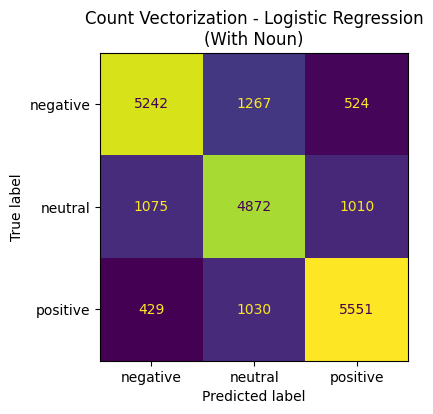

              precision    recall  f1-score   support

    negative       0.78      0.75      0.76      7033
     neutral       0.68      0.70      0.69      6957
    positive       0.78      0.79      0.79      7010

    accuracy                           0.75     21000
   macro avg       0.75      0.75      0.75     21000
weighted avg       0.75      0.75      0.75     21000



In [29]:
# Extract vectorised features from the text data 
# with count word embedding.
countvec_with_noun = CountVectorizer(max_features=2500)

# Fit count vectorisation on training data and
# transform the test data with the fitted vectoriser
X_train_countvec_with_noun = countvec_with_noun.fit_transform(X_train_with_noun)
X_test_countvec_with_noun = countvec_with_noun.transform(X_test_with_noun)

# Fit a logistic regression model to classify the reviews.
countvec_with_noun_model = LogisticRegression(max_iter=500)
countvec_with_noun_model.fit(X_train_countvec_with_noun, y_train_with_noun)

train_pred_class = countvec_with_noun_model.predict(X_train_countvec_with_noun)
test_pred_class = countvec_with_noun_model.predict(X_test_countvec_with_noun)
train_acc_score = accuracy_score(y_train_with_noun, train_pred_class) * 100
test_acc_score = accuracy_score(y_test_with_noun, test_pred_class) * 100
print(f"Classifier Train Accuracy: {train_acc_score:.2f}%")
print(f"Classifier Test Accuracy: {test_acc_score:.2f}%")

fig, ax = plt.subplots(figsize=(4, 4))
cm = confusion_matrix(y_test_with_noun, test_pred_class, labels=countvec_with_noun_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=countvec_with_noun_model.classes_)
disp.plot(ax=ax)
disp.im_.colorbar.remove()
disp.ax_.set_title("Count Vectorization - Logistic Regression\n(With Noun)")
plt.show()
fig.savefig("./report_media/countvec_cm.png")

print(classification_report(y_test_with_noun, test_pred_class))

#### TF-IDF Vectorization

Classifier Train Accuracy: 76.72%
Classifier Test Accuracy: 74.58%


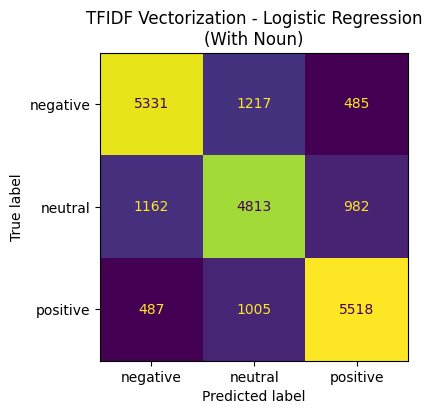

              precision    recall  f1-score   support

    negative       0.76      0.76      0.76      7033
     neutral       0.68      0.69      0.69      6957
    positive       0.79      0.79      0.79      7010

    accuracy                           0.75     21000
   macro avg       0.75      0.75      0.75     21000
weighted avg       0.75      0.75      0.75     21000



In [30]:
# Extract vectorised features from the text data 
# with TF-IDF word embedding.
tfidf_with_noun = TfidfVectorizer(max_features=2500)

# Fit tf-idf vectorisation on training data and
# transform the test data with the fitted vectoriser
X_train_tfidf_with_noun = tfidf_with_noun.fit_transform(X_train_with_noun)
X_test_tfidf_with_noun = tfidf_with_noun.transform(X_test_with_noun)

# Fit a logistic regression model to classify the reviews.
tfidf_with_noun_model = LogisticRegression(max_iter=500)
tfidf_with_noun_model.fit(X_train_tfidf_with_noun, y_train_with_noun)

train_pred_class = tfidf_with_noun_model.predict(X_train_tfidf_with_noun)
test_pred_class = tfidf_with_noun_model.predict(X_test_tfidf_with_noun)
train_acc_score = accuracy_score(y_train_with_noun, train_pred_class) * 100
test_acc_score = accuracy_score(y_test_with_noun, test_pred_class) * 100
print(f"Classifier Train Accuracy: {train_acc_score:.2f}%")
print(f"Classifier Test Accuracy: {test_acc_score:.2f}%")

fig, ax = plt.subplots(figsize=(4, 4))
cm = confusion_matrix(y_test_with_noun, test_pred_class, labels=tfidf_with_noun_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tfidf_with_noun_model.classes_)
disp.plot(ax=ax)
disp.im_.colorbar.remove()
disp.ax_.set_title("TFIDF Vectorization - Logistic Regression\n(With Noun)")
plt.show()
fig.savefig("./report_media/tfidf_cm.png")

print(classification_report(y_test_with_noun, test_pred_class))

### Sentiment predictions by count vectorization logistic regression model
Count and percentages of sentiments by vaccine manufacturers

In [31]:
# Make predictions on the full dataset with noun
X_countvec_with_noun = countvec_with_noun.transform(X_with_noun)
reduced_df["log_reg_predictions"] = countvec_with_noun_model.predict(X_countvec_with_noun)

Plot stacked bar plots as before

,covaxin,sinopharm,sinovac,moderna,pfizer|biontech,oxford|astrazeneca,sputnik
sentiment,,,,,,,
negative,5665,1037,1582,8210,4312,1746,2230
neutral,8511,2583,2448,7730,4490,1482,4273
positive,7523,637,2139,12638,3840,1175,1585


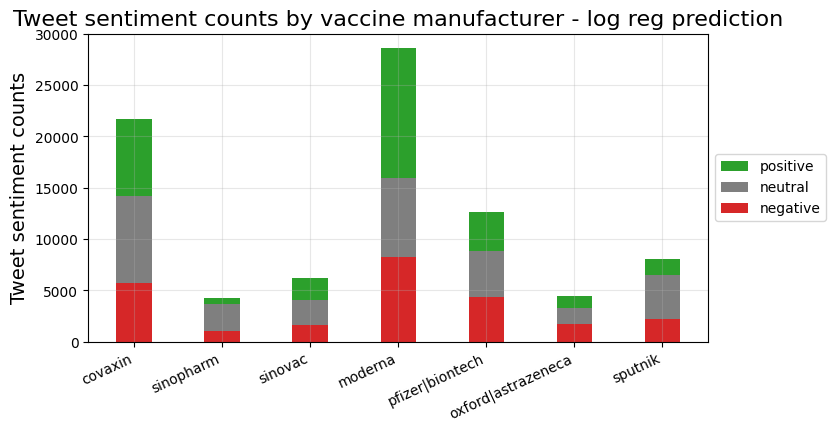

,covaxin,sinopharm,sinovac,moderna,pfizer|biontech,oxford|astrazeneca,sputnik
sentiment,,,,,,,
negative,26.1,24.4,25.6,28.7,34.1,39.7,27.6
neutral,39.2,60.7,39.7,27.0,35.5,33.7,52.8
positive,34.7,15.0,34.7,44.2,30.4,26.7,19.6


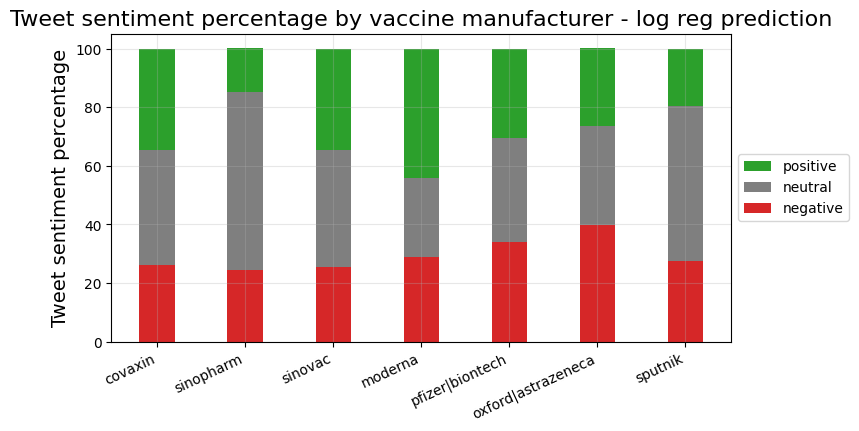

In [32]:
# Count
df = pd.DataFrame(["negative", "neutral", "positive"], columns=["sentiment"])

for name in all_vax:
    
    temp_df = reduced_df.loc[
        reduced_df["preprocessed_text"].str.contains(name), "log_reg_predictions"
    ].value_counts().reset_index(name=name).rename(columns={'index': 'sentiment'})
    
    df = pd.merge(df, temp_df, on="sentiment", how="inner")

counts_df = df.set_index("sentiment")
display(counts_df)

neg = counts_df.loc["negative"].values.flatten()
neu = counts_df.loc["neutral"].values.flatten()
pos = counts_df.loc["positive"].values.flatten()

width = 0.4
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(all_vax, pos, width, label="positive", color="tab:green", bottom=neg+neu)
ax.bar(all_vax, neu, width, label="neutral", color="tab:gray", bottom=neg)
ax.bar(all_vax, neg, width, label="negative", color="tab:red")
ax.set_ylabel("Tweet sentiment counts", fontsize=14)
ax.set_title("Tweet sentiment counts by vaccine manufacturer - log reg prediction", fontsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(alpha=0.3)
for label in ax.get_xticklabels(which="major"):
    label.set(rotation=25, horizontalalignment="right")
plt.show()
fig.savefig("./report_media/sentiment_count_logreg.png", bbox_inches='tight', pad_inches=0.1)

# Percentage
pct_df = (100 * counts_df / counts_df.sum()).round(1)
display(pct_df)

neg = pct_df.loc["negative"].values.flatten()
neu = pct_df.loc["neutral"].values.flatten()
pos = pct_df.loc["positive"].values.flatten()

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(all_vax, pos, width, label="positive", color="tab:green", bottom=neg+neu)
ax.bar(all_vax, neu, width, label="neutral", color="tab:gray", bottom=neg)
ax.bar(all_vax, neg, width, label="negative", color="tab:red")
ax.set_ylabel("Tweet sentiment percentage", fontsize=14)
ax.set_title("Tweet sentiment percentage by vaccine manufacturer - log reg prediction", fontsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(alpha=0.3)
for label in ax.get_xticklabels(which="major"):
    label.set(rotation=25, horizontalalignment="right")
plt.show()
fig.savefig("./report_media/sentiment_percentage_logreg.png", bbox_inches='tight', pad_inches=0.1)


### Proportions of tweet sentiments over time - predicted by log reg

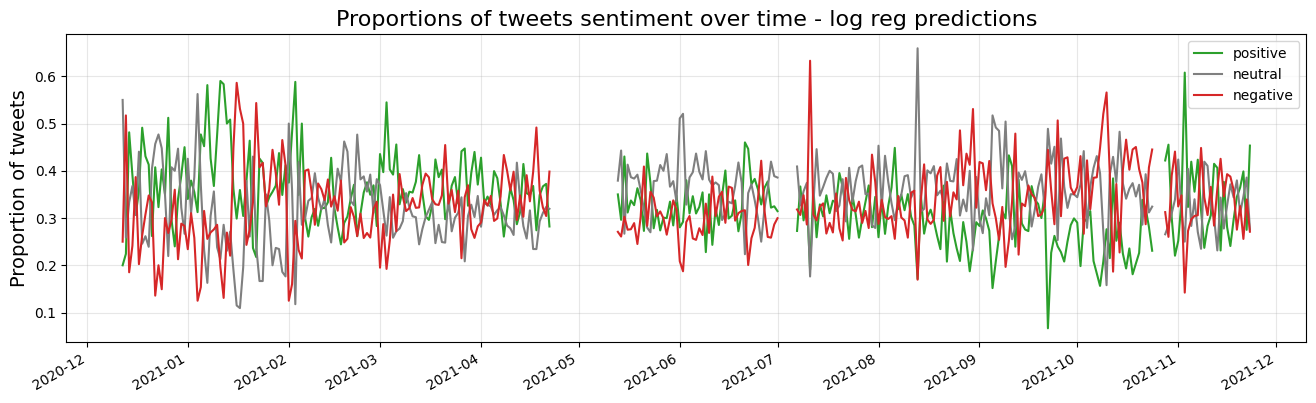

In [33]:
date_count_df = reduced_df.groupby("fulldate").value_counts(subset=["log_reg_predictions"]).reset_index(name="count")

pivot_date_count_df = date_count_df.pivot(index="fulldate", columns="log_reg_predictions", values="count").reset_index()

start_date = reduced_df["fulldate"].min()
end_date = reduced_df["fulldate"].max()
all_dates = pd.DataFrame(pd.date_range(start=start_date, end=end_date), columns=["fulldate"])
all_dates["fulldate"] = pd.to_datetime(all_dates["fulldate"]).dt.date

pivot_date_count_df["fulldate"] = pd.to_datetime(pivot_date_count_df["fulldate"]).dt.date

pivot_date_count_all = pd.merge(
    pivot_date_count_df, all_dates, on="fulldate", how="outer"
).fillna(0).sort_values(by="fulldate")

counts = list(
    zip(pivot_date_count_all["negative"], pivot_date_count_all["neutral"], pivot_date_count_all["positive"])
)
percentages = [
    [None if np.isclose(np.array(date_counts).sum(), 0) else v/np.array(date_counts).sum() for v in date_counts] 
    for date_counts in counts
]

neg_pct = [p[0] for p in percentages]
neu_pct = [p[1] for p in percentages]
pos_pct = [p[2] for p in percentages]

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(pivot_date_count_all["fulldate"], pos_pct, color="tab:green", label="positive")
ax.plot(pivot_date_count_all["fulldate"], neu_pct, color="tab:gray", label="neutral")
ax.plot(pivot_date_count_all["fulldate"], neg_pct, color="tab:red", label="negative")
ax.grid(alpha=0.3)

# Date axis labels
ax.xaxis.set_major_locator(mdates.MonthLocator())
for label in ax.get_xticklabels(which="major"):
    label.set(rotation=30, horizontalalignment="right")

ax.set_title("Proportions of tweets sentiment over time - log reg predictions", fontsize=16)
ax.set_ylabel("Proportion of tweets", fontsize=14)
ax.legend()
plt.show()
fig.savefig("./report_media/time_sentiment_logreg.png")

In [34]:
# The negative sentiment days appear to be on 2021-07-11
with pd.option_context('display.max_rows', None):
    display(reduced_df.loc[(reduced_df["fulldate"] == "2021-07-12") & (reduced_df["max_score_label"] == "negative"), ["user_name", "text"]])

,user_name,text
325,Juarawee K. (Lina),"Earlier, Thailand reports a nurse who died from #covid19 even after 2 doses of #sinovac 💉. Today, it announces a st… https://t.co/F96zl9bIUW"
470,Timothy Caulfield,"Spoiler: No, no, no, no, no! \n\n""Can the #Pfizer or #Moderna mRNA #COVID Vaccines Affect Your Genetic Code?""… https://t.co/15KTqgrSCs"
682,Oak Consult Health,#Pfizer and #Moderna vaccines: UK adds rare heart inflammation to side effects https://t.co/CJ2tHdvxeG @CityAM https://t.co/TRAvgnn6Hn
986,Duranta🇹🇷🇮🇪🏳️‍🌈,@mollydot Dear @mollydot it won't because Ireland does not recognise vaccines like @Sinovac or #Sinopharm which wer… https://t.co/rZpmtfilK8
1766,Toughone,The fact that Republicans continue to push conspiracy about vaccines is a public health hazard. @Pfizer #Moderna &amp;… https://t.co/TcsodCs3ZI
1882,=^..^=,#Fauci is a fraudster with financial interest in #Moderna clearly a huge #ConflictofInterest yet he never took vaxx… https://t.co/7D9WCVoHWI
2011,Ceris Sadzik,10.03... Not working!\n#VaccineForAll #moderna #samitivej\n@RichardBarrow https://t.co/S9XW3BnBoH
2420,Shivadas Menon,Now I’m hearing Coronavac (Sinovac) is probably not strong enough to handle the Delta variant. I just got my Sinova… https://t.co/i5OR1INat4
2579,Muhit,"618 @MFAThai medical workers out of 677,348 personnel who received 2 doses of #Sinovac became infected… https://t.co/SP2f9BOLOz"
2661,Rich,@pmdscully #PhuketSandBox in deep trouble with 90% of the vaccinations being #Sinovac https://t.co/HeFeacsag2


Average number of words in pre-processed text columns

In [35]:
avg_num_words_no_noun = reduced_df.loc[
    ~reduced_df["preprocessed_text_no_noun"].isna(),
    "preprocessed_text_no_noun"
].apply(lambda x: len(x.split(' '))).mean()
print(f"Average Number of Words per Document (no nouns): {avg_num_words_no_noun:.2f}")

avg_num_words = reduced_df.loc[
    ~reduced_df["preprocessed_text"].isna(),
    "preprocessed_text"
].apply(lambda x: len(x.split(' '))).mean()
print(f"Average Number of Words per Document (with nouns): {avg_num_words:.2f}")

Average Number of Words per Document (no nouns): 4.23
Average Number of Words per Document (with nouns): 10.24


Print the runtime

In [36]:
print(f"Notebook runtime: {time.time() - start_time:.3f}s")

Notebook runtime: 2455.579s
